<a href="https://colab.research.google.com/github/sithumonline/Halftone/blob/main/Halftone0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget https://raw.githubusercontent.com/GravO8/halftone/master/halftone.py

--2021-11-15 09:13:09--  https://raw.githubusercontent.com/GravO8/halftone/master/halftone.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5320 (5.2K) [text/plain]
Saving to: ‘halftone.py’

halftone.py         100%[===================>]   5.20K  --.-KB/s    in 0s      

2021-11-15 09:13:09 (59.2 MB/s) - ‘halftone.py’ saved [5320/5320]



In [ ]:
!python3 halftone.py foo-y.jpg -fg '(255, 255,0)' --side 7 

python3: can't open file 'halftone.py': [Errno 2] No such file or directory


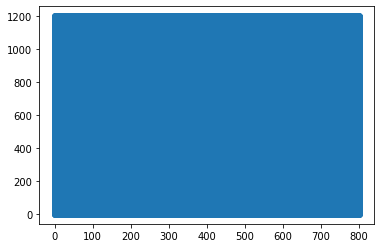

In [ ]:
from PIL import Image

im  = Image.open('foo.jpg')             # open RGB image
cmyk= im.convert('CMYK').split()         # RGB contone RGB to CMYK contone
c = cmyk[0].convert('1').convert('L')    # and then halftone ('1') each plane
m = cmyk[1].convert('1').convert('L')    # ...and back to ('L') mode
y = cmyk[2].convert('1').convert('L')
k = cmyk[3].convert('1').convert('L')

new_cmyk = Image.merge('CMYK',[c,m,y,k]) # put together all 4 planes
new_cmyk.save('foo-cmyk.jpg')           # and save to file

"""
# Get X,Y coordinates of image
for x in range(c.size[0]):
    for y in range(c.size[1]):
        if c.getpixel((x,y)) == 0:
            continue
        # print(f'x : {x}, y : {y}')
"""
"""
with open('foo-xy.gcode', 'w') as f:
    for x in range(c.size[0]):
        for y in range(c.size[1]):
            if c.getpixel((x,y)) == 0:
                continue
            f.write(f'G82 X{x} Y{y}\n')
"""
import matplotlib.pyplot as plt
arr_x = []
arr_y = []
for x in range(c.size[0]):
    for y in range(c.size[1]):
        if c.getpixel((x,y)) == 0:
            continue
        arr_x.append(x)
        arr_y.append(y)
plt.scatter(arr_x, arr_y)

plt.show()


In [ ]:
from PIL import Image, ImageDraw, ImageStat

def gcr(im, percentage):
    '''basic "Gray Component Replacement" function. Returns a CMYK image with 
       percentage gray component removed from the CMY channels and put in the
       K channel, ie. for percentage=100, (41, 100, 255, 0) >> (0, 59, 214, 41)'''
    cmyk_im = im.convert('CMYK')
    if not percentage:
        return cmyk_im
    cmyk_im = cmyk_im.split()
    cmyk = []
    for i in range(4):
        cmyk.append(cmyk_im[i].load())
    for x in xrange(im.size[0]):
        for y in xrange(im.size[1]):
            gray = min(cmyk[0][x,y], cmyk[1][x,y], cmyk[2][x,y]) * percentage / 100
            for i in xrange(3):
                cmyk[i][x,y] = cmyk[i][x,y] - gray
            cmyk[3][x,y] = gray
    return Image.merge('CMYK', cmyk_im)

def halftone(im, cmyk, sample, scale):
    '''Returns list of half-tone images for cmyk image. sample (pixels), 
       determines the sample box size from the original image. The maximum 
       output dot diameter is given by sample * scale (which is also the number 
       of possible dot sizes). So sample=1 will presevere the original image 
       resolution, but scale must be >1 to allow variation in dot size.'''
    cmyk = cmyk.split()
    dots = []
    angle = 0
    for channel in cmyk:
        channel = channel.rotate(angle, expand=1)
        size = channel.size[0]*scale, channel.size[1]*scale
        half_tone = Image.new('L', size)
        draw = ImageDraw.Draw(half_tone)
        for x in range(0, channel.size[0], sample):
            for y in range(0, channel.size[1], sample):
                box = channel.crop((x, y, x + sample, y + sample))
                stat = ImageStat.Stat(box)
                diameter = (stat.mean[0] / 255)**0.5
                edge = 0.5*(1-diameter)
                x_pos, y_pos = (x+edge)*scale, (y+edge)*scale
                box_edge = sample*diameter*scale
                draw.ellipse((x_pos, y_pos, x_pos + box_edge, y_pos + box_edge), fill=255)
        half_tone = half_tone.rotate(-angle, expand=1)
        width_half, height_half = half_tone.size
        xx=(width_half-im.size[0]*scale) / 2
        yy=(height_half-im.size[1]*scale) / 2
        half_tone = half_tone.crop((xx, yy, xx + im.size[0]*scale, yy + im.size[1]*scale))
        dots.append(half_tone)
        angle += 15
    return dots

im = Image.open("foo.jpg")

cmyk = gcr(im, 0)
dots = halftone(im, cmyk, 10, 4)
#im.show()
new = Image.merge('CMYK', dots)
new.save('foo-cmyk-s4.jpg')